# VQSD Demo
This is a circuit demonstratinga (not yet) scalable implementation of the VQSD algorithm in pennylane.

In [35]:
# imports
import pennylane as qml
from pennylane import numpy as np

In [36]:
# define device
n_qubits = 1
dev = qml.device("default.mixed", wires=n_qubits*2)

In [37]:
n_layers = 2 # num parameter layers
shape = qml.RandomLayers.shape(n_layers=n_layers, n_rotations=2) # properly define the shape of the gate layers

In [50]:
import math
input_state = [1/math.sqrt(2), 1/math.sqrt(2)]
U = np.array([input_state,[0,0]])

In [51]:
# Create a default.mixed device
dev = qml.device("default.qubit", wires=2) #TODO: change to default.mixed in prod

target_purity = 1 #target purity

# Create a qnode
@qml.qnode(dev)
def purity_circuit(purity):
    # Add some gates #should I be changing this part too??
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    # Add some noise (optional)
    # qml.BitFlip(1 - purity, wires=0)
    # Return the state of the system
    return qml.state()

qml.qinfo.transforms.purity(purity_circuit, wires=[0, 1])(target_purity) #TODO: tweak this hyperparameter

tensor(1., requires_grad=True)

In [52]:
# circuit for dephase
@qml.qnode(dev)
def ansatz(weights):
    for i in range(n_qubits*2): # initial state TODO: change this to accomodate multiple qubits
        qml.QubitUnitary(U, wires=i)
        # qml.Hadamard(wires=i)
        
    qml.RandomLayers(weights=weights, wires=range(n_qubits)) # should be the alternating one but idk how to implement that
    qml.RandomLayers(weights=weights, wires=range(n_qubits, 2*n_qubits)) # second circuit with the exact same weights as the first
    
    # cost function (DIP test)
    for i in range(n_qubits):
        qml.CNOT(wires=[i, n_qubits + i])
    # operator = generate_operator(n_qubits)
    probs = qml.probs(wires=range(n_qubits, n_qubits*2)) # trace(dephased(p^2))
    return probs

weights = np.random.random(size=shape)
print(qml.draw(ansatz, expansion_strategy="device")(weights))

0: ──U(M0)──RX(0.21)──RX(0.18)──RZ(0.18)──RY(0.30)─╭●─┤       
1: ──U(M0)──RX(0.21)──RX(0.18)──RZ(0.18)──RY(0.30)─╰X─┤  Probs


In [53]:
# cost function
def cost_fn(param):
    purity = qml.qinfo.transforms.purity(purity_circuit, wires=[0, 1])(target_purity)
    probs = ansatz(param)
    dephase = probs[0]
    # print(probs, purity)
    return purity - probs[0] # tr(p^2) - tr(Z(p)^2)

In [54]:
#initialize random weights for the circuit
init_params = np.random.random(size=shape)
print(cost_fn(init_params))

0.7825646253034122


In [55]:
# optimization loop
opt = qml.GradientDescentOptimizer(stepsize=0.4)
steps = 100
params = init_params

costs = []

for i in range(steps):
    params = opt.step(cost_fn, params)
    costs.append(cost_fn(params))
    
    
    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost_fn(params)))

print("Optimized rotation angles: {}".format(params))

Cost after step     5:  0.7565876
Cost after step    10:  0.7514901
Cost after step    15:  0.7504412
Cost after step    20:  0.7501503
Cost after step    25:  0.7500538
Cost after step    30:  0.7500195
Cost after step    35:  0.7500071
Cost after step    40:  0.7500026
Cost after step    45:  0.7500009
Cost after step    50:  0.7500003
Cost after step    55:  0.7500001
Cost after step    60:  0.7500000
Cost after step    65:  0.7500000
Cost after step    70:  0.7500000
Cost after step    75:  0.7500000
Cost after step    80:  0.7500000
Cost after step    85:  0.7500000
Cost after step    90:  0.7500000
Cost after step    95:  0.7500000
Cost after step   100:  0.7500000
Optimized rotation angles: [[ 1.52555567e-02 -1.52585867e-02]
 [ 1.46865052e-01  1.07788789e-05]]


In [56]:
# eigenvalue readout
dev = qml.device("default.qubit", wires=n_qubits)
@qml.qnode(dev)
def circuit2(weights):
    for i in range(n_qubits): # initial state TODO: change this to be able to represent any initial matrix
        qml.Hadamard(i)
        # qml.RX(weights[0], wires=i)
        # qml.RY(weights[1], wires=i)
        # qml.RZ(weights[2], wires=i)
    qml.RandomLayers(weights=weights, wires=range(n_qubits)) # should be the alternating one but idk how to implement that
    
    # measure in standard gasis
    return qml.probs() # change to just a regular measurement and that bitstring is the binary representation of the eigenvalue

print(qml.draw(circuit2, expansion_strategy="device")(params))

0: ──H──RX(0.02)──RX(-0.02)──RZ(0.15)──RY(0.00)─┤  Probs


In [57]:
print(circuit2(params)) # there will always be 2^n eigenvalues that sum to 1

[0.49999467 0.50000533]


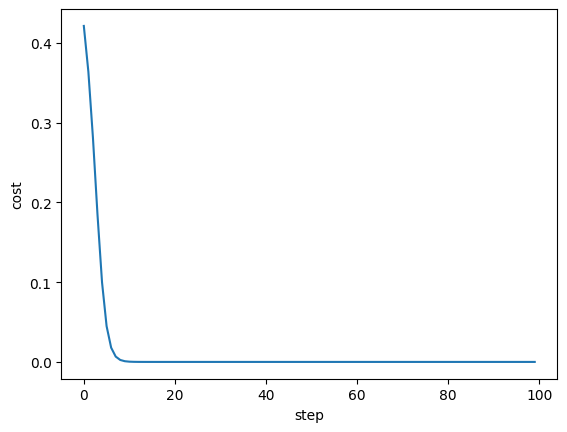

In [46]:
import matplotlib.pyplot as plt

plt.plot([x for x in range(steps)], costs)
plt.xlabel("step")
plt.ylabel("cost")
plt.show()